In [12]:
import os
import os.path as osp
import time
import math
import numpy as np
import random
from datetime import timedelta
from argparse import ArgumentParser
import yaml
from dotmap import DotMap

import torch
from torch import cuda
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from tqdm import tqdm

from east_dataset import EASTDataset
from dataset import SceneTextDataset
from model import EAST
import wandb
import shutil

import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [13]:
from argparse import ArgumentParser
import os
import torch
from dotmap import DotMap

def parse_args():
    parser = ArgumentParser()

    # Conventional args
    parser.add_argument('--data_dir', type=str,
                        default=os.environ.get('SM_CHANNEL_TRAIN', 'data'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR', 'trained_models'))

    parser.add_argument('--device', default='cuda' if torch.cuda.is_available() else 'cpu')
    parser.add_argument('--num_workers', type=int, default=8)

    parser.add_argument('--image_size', type=int, default=2048)
    parser.add_argument('--input_size', type=int, default=1024)
    parser.add_argument('--batch_size', type=int, default=1)
    parser.add_argument('--learning_rate', type=float, default=1e-3)
    parser.add_argument('--max_epoch', type=int, default=150)
    parser.add_argument('--save_interval', type=int, default=5)
    
    args = parser.parse_args()

    if args.input_size % 32 != 0:
        raise ValueError('`input_size` must be a multiple of 32')

    # Config를 DotMap 형태로 변환
    config = DotMap({
        'data': {
            'data_dir': args.data_dir,
            'image_size': args.image_size,
            'input_size': args.input_size,
            'batch_size': args.batch_size
        },
        'model': {
            'model_dir': args.model_dir
        },
        'solver': {
            'learning_rate': args.learning_rate,
            'max_epoch': args.max_epoch,
            'save_interval': args.save_interval
        },
        'device': args.device,
        'num_workers': args.num_workers
    })

    return config


In [14]:
def initialize_directory(config):
    model_dir = config.data.model_dir
    if not osp.exists(model_dir):
        os.makedirs(model_dir)
    log_dir = osp.join(model_dir, config.exp_name)
    if not osp.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir    

In [15]:
def update_log(log_dir, epoch, mean_loss, elapsed_time):
    log_path = osp.join(log_dir, 'training_log.txt')
    with open(log_path, 'a') as f:
        f.write(f"Epoch: {epoch + 1}, Mean Loss: {mean_loss:.4f}, Elapsed Time: {elapsed_time}\n")


In [36]:
# config.yaml 파일의 경로를 설정
config_file_path = '/data/ephemeral/home/ES-datacentric-cv-09/config/config.yaml'

# YAML 파일 읽기
with open(config_file_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config = DotMap(config)

# check image size
if config.data.input_size % 32 != 0:
    raise ValueError('`input_size` must be a multiple of 32')

log_dir = initialize_directory(config)

dataset = SceneTextDataset(
    config.data.data_dir,
    split='train',
    image_size=config.data.image_size,
    crop_size=config.data.input_size,
)

Image shape: (1024, 1024, 3)
Word bounding boxes shape: (19, 4, 2)
[[[ 786.67082181   52.67023029]
  [1003.37257976   46.14670791]
  [1006.79024396  159.67645417]
  [ 790.08848601  166.19997654]]

 [[ 791.18694424  182.14533547]
  [ 999.9119997   174.64996669]
  [1002.10136698  236.4443449 ]
  [ 793.37630785  243.93959166]]

 [[ 864.42292929  257.05687983]
  [1006.11862776  251.82176132]
  [1010.23417836  365.80788764]
  [ 868.53848356  371.04312816]]

 [[ 395.27438139  604.16291267]
  [ 938.40319691  591.58702364]
  [ 940.00524903  659.10515717]
  [ 396.87642985  671.68092419]]

 [[ 748.12014321  686.330528  ]
  [ 792.89978419  684.9824956 ]
  [ 793.67880889  710.86054301]
  [ 748.89916791  712.2085754 ]]

 [[ 817.96212212  668.10488135]
  [ 858.87244827  665.75856702]
  [ 862.04673557  723.36552904]
  [ 821.13629108  725.71196906]]

 [[ 889.83203173  687.91319503]
  [ 933.01229959  686.61330967]
  [ 933.46463853  701.63933959]
  [ 890.28437067  702.93922495]]

 [[ 960.99775234  664.5

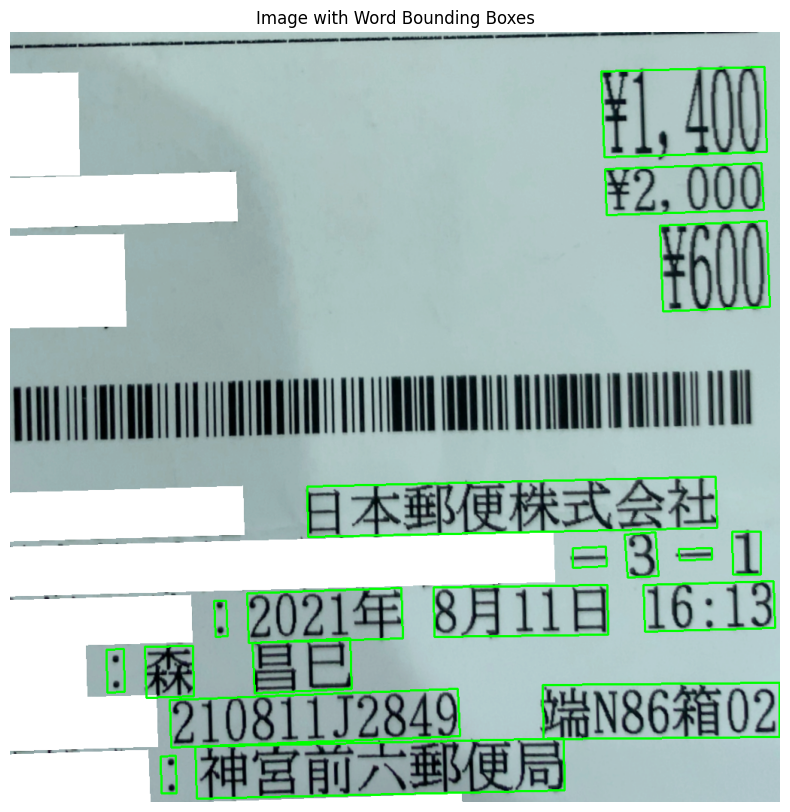

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

image, word_bboxes, roi_mask = dataset[83]

def visualize_image_with_bboxes(image, word_bboxes):
    # 텐서 이미지(배치 크기 포함)를 Numpy 배열로 변환하여 HWC 형태로 바꾸기
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()  # C, H, W -> H, W, C

    # 데이터 타입 및 크기 출력
    print("Image shape:", image.shape)
    print("Image dtype:", image.dtype)

    # 이미지 정규화 해제 및 값 범위 조정
    if image.dtype == np.float32 or image.dtype == np.float64:
        # 값이 음수인 경우 0-1 범위로 재조정
        image = (image - image.min()) / (image.max() - image.min())
        print("Image after normalization:", image.min(), image.max())  # 정규화 후 최소, 최대 값
        
        # 0-1 범위의 float 이미지를 0-255의 uint8로 변환
        image = (image * 255).astype(np.uint8)
        print("Image after scaling:", image.min(), image.max())  # 스케일링 후 최소, 최대 값

    # 이미지 복사본을 생성하여 Bounding boxes를 이미지에 그리기
    image_with_bboxes = image.copy()

    # Bounding boxes를 이미지에 그리기
    for bbox in word_bboxes:
        # 각 bbox의 좌표를 정수로 변환
        pts = np.array(bbox, np.int32).reshape((-1, 1, 2))
        
        # 이미지에 폴리곤 그리기
        image_with_bboxes = cv2.polylines(image_with_bboxes, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

    # 이미지 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_with_bboxes, cv2.COLOR_BGR2RGB))  # BGR -> RGB로 변환
    plt.title("Image with Word Bounding Boxes")
    plt.axis('off')
    plt.show()

# 시각화 함수 실행
visualize_image_with_bboxes(image, word_bboxes)



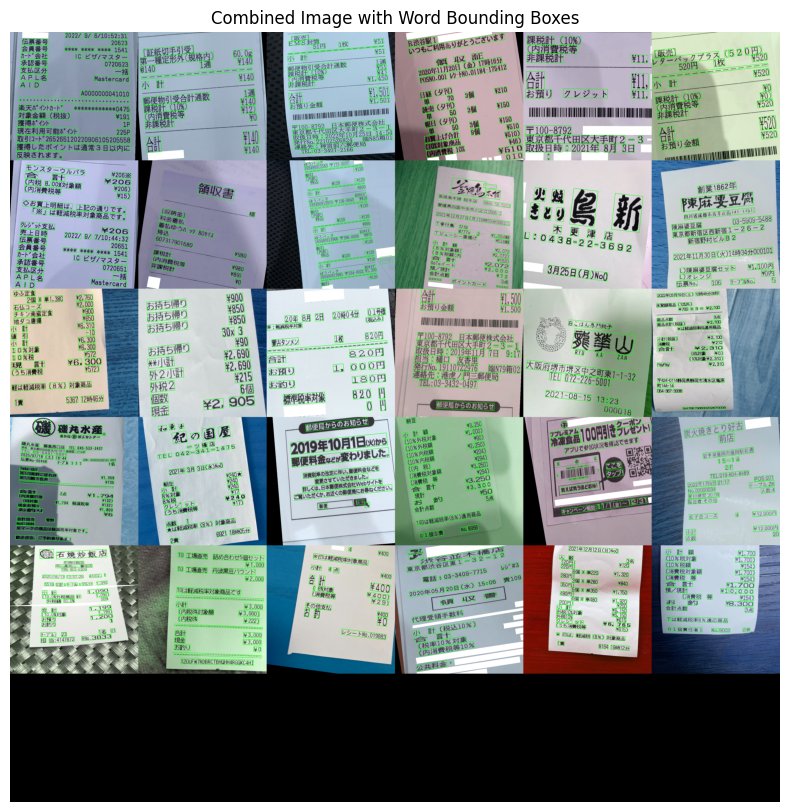

In [38]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

def visualize_images_with_bboxes(dataset, num_images=30, save_path='/data/ephemeral/home/ES-datacentric-cv-09/code/data/augmented_samples.jpg'):
    # 시각화할 이미지 수 제한
    num_images = min(num_images, len(dataset))
    
    # 각 이미지에 대한 설정
    images = []
    
    for i in range(num_images):
        image, word_bboxes, roi_mask = dataset[i]  # 데이터셋에서 이미지 가져오기
        
        # 텐서 이미지(배치 크기 포함)를 Numpy 배열로 변환하여 HWC 형태로 바꾸기
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()  # C, H, W -> H, W, C

        # 이미지 정규화 해제 및 값 범위 조정
        if image.dtype == np.float32 or image.dtype == np.float64:
            image = (image - image.min()) / (image.max() - image.min())
            image = (image * 255).astype(np.uint8)

        # 이미지 복사본을 생성하여 Bounding boxes를 이미지에 그리기
        image_with_bboxes = image.copy()

        # Bounding boxes를 이미지에 그리기
        for bbox in word_bboxes:
            pts = np.array(bbox, np.int32).reshape((-1, 1, 2))
            image_with_bboxes = cv2.polylines(image_with_bboxes, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
        
        images.append(cv2.cvtColor(image_with_bboxes, cv2.COLOR_BGR2RGB))  # BGR -> RGB로 변환 후 리스트에 추가
    
    # 그리드 형태로 이미지 저장
    grid_size = int(np.ceil(np.sqrt(num_images)))  # 그리드 크기 계산

    # 각 이미지의 크기 가져오기
    h, w, _ = images[0].shape  # 첫 번째 이미지 크기로 설정

    combined_image = np.zeros((grid_size * h, grid_size * w, 3), dtype=np.uint8)  # 이미지 크기로 결합된 이미지 생성

    for idx, img in enumerate(images):
        row = idx // grid_size
        col = idx % grid_size
        combined_image[row * h:(row + 1) * h, col * w:(col + 1) * w] = img
    
    # 전체 이미지를 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(combined_image)
    plt.axis('off')
    plt.title("Combined Image with Word Bounding Boxes")
    plt.show()
    
    # 이미지를 저장
    cv2.imwrite(save_path, cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))  # RGB -> BGR로 변환하여 저장

# 시각화 및 저장 함수 실행
visualize_images_with_bboxes(dataset, num_images=30)


In [18]:
# roi_mask의 실제 형태 확인
print("roi_mask shape:", roi_mask.shape)


roi_mask shape: (1024, 1024)


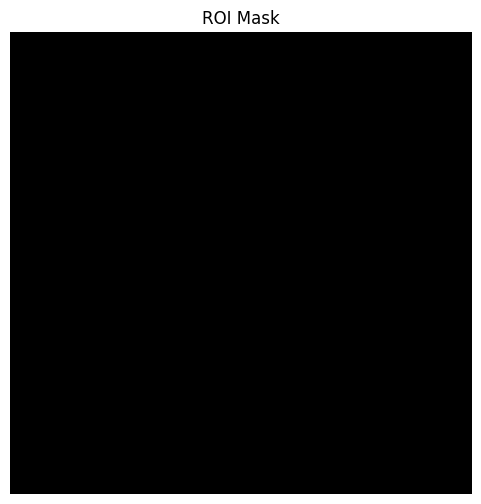

In [19]:
import matplotlib.pyplot as plt

# roi_mask 시각화
plt.figure(figsize=(6, 6))  # 시각화 크기 설정
plt.imshow(roi_mask, cmap='gray')  # roi_mask를 시각화
plt.title("ROI Mask")  # 제목 추가
plt.axis('off')  # 축 숨기기
plt.show()  # 이미지 표시


In [20]:
dataset = EASTDataset(dataset)
num_batches = math.ceil(len(dataset) / config.data.batch_size)
train_loader = DataLoader(
    dataset,
    batch_size=config.data.batch_size,
    shuffle=True,
    num_workers=config.data.num_workers,
    pin_memory=True
)

In [21]:
img, gt_score_map, gt_geo_map, roi_mask = next(iter(train_loader))

In [30]:
# 이미지와 마스크 리스트
images = {
    "img": img,
    "gt_score_map": gt_score_map,
    "gt_geo_map": gt_geo_map,
    "roi_mask": roi_mask
}

# 각 이미지의 크기와 값을 출력
for name, image in images.items():
    print(f"{name} - Shape: {image.shape}")
    # print(f"{name} - Values:\n{image}\n")


img - Shape: torch.Size([8, 3, 1024, 1024])
gt_score_map - Shape: torch.Size([8, 1, 512, 512])
gt_geo_map - Shape: torch.Size([5, 512, 512])
roi_mask - Shape: torch.Size([8, 1, 512, 512])


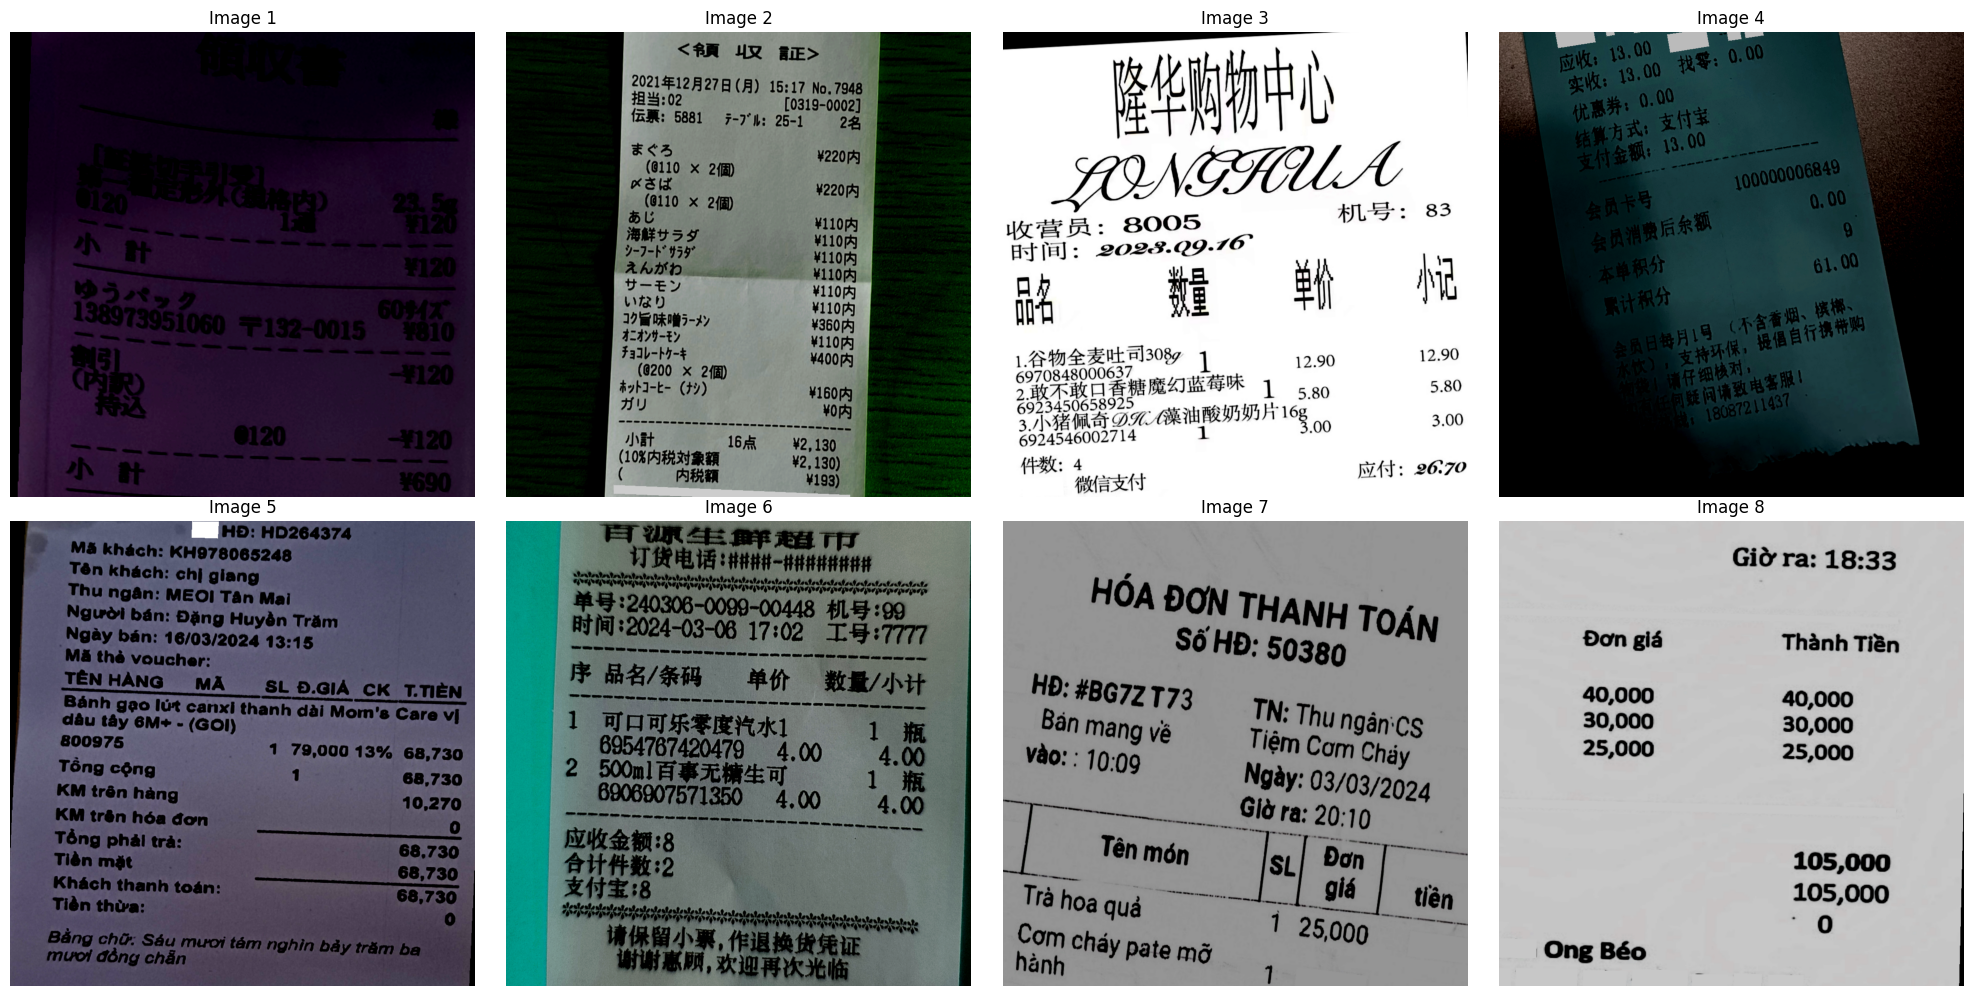

TypeError: Invalid shape (512,) for image data

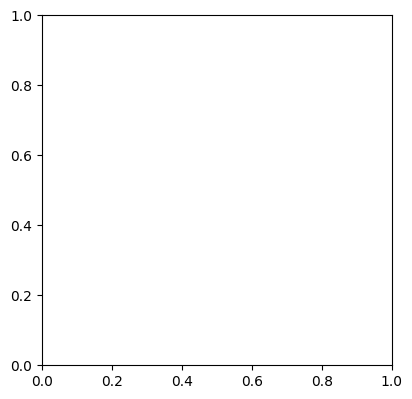

In [31]:
def visualize_images(img_tensor):
    batch_size = img_tensor.shape[0]  # 배치 크기
    plt.figure(figsize=(20, 10))  # 전체 그림 크기 설정

    for i in range(batch_size):
        img = img_tensor[i].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)로 변환
        plt.subplot(2, batch_size // 2, i + 1)  # 2행으로 배치, 적절한 열 수 설정
        plt.imshow(img)  # 이미지 표시
        plt.title(f"Image {i + 1}")  # 각 이미지에 제목 설정
        plt.axis('off')  # 축 숨기기

    plt.tight_layout()  # 레이아웃 조정
    plt.show()  # 이미지 표시

# img_tensor를 visualize_images 함수에 넘겨주기
visualize_images(img)

def visualize_batch_combined_gt_geo_map(gt_geo_map_batch):
    batch_size = gt_geo_map_batch.shape[0]  # 배치 크기
    plt.figure(figsize=(20, 10))  # 전체 그림 크기 설정

    for i in range(batch_size):
        # 각 배치의 gt_geo_map 채널을 결합하여 단일 이미지 생성
        combined_map = gt_geo_map_batch[i].sum(axis=0)  # (5, H, W) -> (H, W)
        plt.subplot(2, batch_size // 2, i + 1)  # 2행으로 배치, 적절한 열 수 설정
        plt.imshow(combined_map.cpu().numpy(), cmap='jet')  # 이미지 표시, cmap으로 색상 설정
        plt.title(f"Combined GT Geo Map {i + 1}")  # 각 이미지에 제목 설정
        plt.axis('off')  # 축 숨기기

    plt.tight_layout()  # 레이아웃 조정
    plt.show()  # 이미지 표시

# 배치의 모든 결합된 gt_geo_map 시각화
visualize_batch_combined_gt_geo_map(gt_geo_map)

TypeError: Invalid shape (512,) for image data

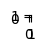

In [32]:
def visualize_gt_geo_map(gt_geo_map):
    # gt_geo_map의 채널 수를 가져오기
    num_channels = gt_geo_map.shape[0]
    
    # 채널 수에 맞게 서브플롯 설정, figsize를 더 크게 조정
    plt.figure(figsize=(20, 10))  # 이미지 크기 조정
    
    for i in range(num_channels):
        plt.subplot(1, num_channels, i + 1)  # 1행 num_channels열의 서브플롯
        plt.imshow(gt_geo_map[i].cpu().numpy(), cmap='jet')  # cmap='jet'로 시각화
        plt.title(f'Channel {i + 1}')  # 각 채널 제목
        plt.axis('off')  # 축 숨기기

    plt.tight_layout()
    plt.show()

# gt_geo_map 시각화
visualize_gt_geo_map(gt_geo_map[0])


tensor([[[-0.9529, -0.9529, -0.9529,  ..., -0.0039, -0.0118, -0.0118],
         [-0.9529, -0.9529, -0.9529,  ..., -0.0039, -0.0118, -0.0118],
         [-0.9529, -0.9529, -0.9529,  ..., -0.0039, -0.0118, -0.0118],
         ...,
         [-0.9529, -0.9529, -0.9529,  ...,  0.1451,  0.1529,  0.1529],
         [-0.9529, -0.9529, -0.9529,  ...,  0.1451,  0.1529,  0.1529],
         [-0.9529, -0.9529, -0.9529,  ...,  0.1451,  0.1529,  0.1529]],

        [[-0.9529, -0.9529, -0.9529,  ..., -0.0980, -0.0980, -0.0980],
         [-0.9529, -0.9529, -0.9529,  ..., -0.0980, -0.0980, -0.0980],
         [-0.9529, -0.9529, -0.9529,  ..., -0.0980, -0.0980, -0.0980],
         ...,
         [-0.9529, -0.9529, -0.9529,  ...,  0.0824,  0.0824,  0.0824],
         [-0.9529, -0.9529, -0.9529,  ...,  0.0745,  0.0824,  0.0824],
         [-0.9529, -0.9529, -0.9529,  ...,  0.0745,  0.0824,  0.0824]],

        [[-0.9529, -0.9529, -0.9529,  ...,  0.0275,  0.0196,  0.0196],
         [-0.9529, -0.9529, -0.9529,  ...,  0

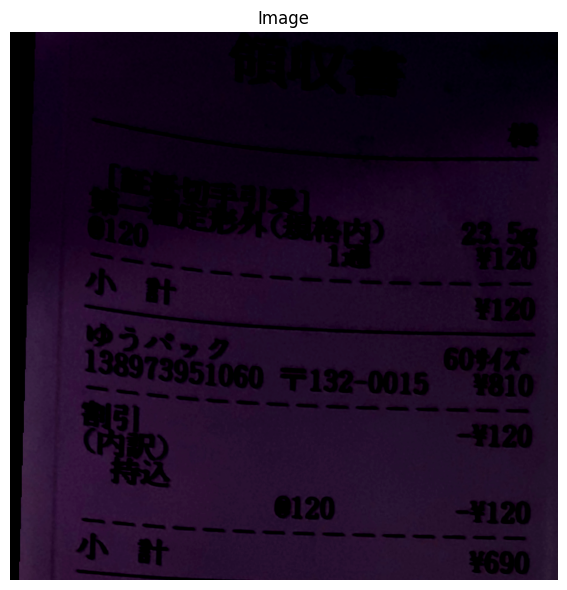

TypeError: Invalid shape (512,) for image data

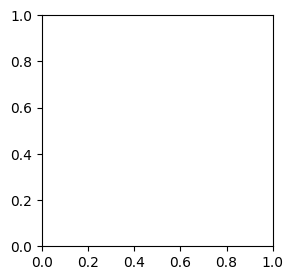

In [33]:
img_sample = img[0].cpu().numpy().transpose(1, 2, 0)  # 채널 순서 조정

print(img[0])
plt.figure(figsize=(10, 6))
plt.imshow(img_sample)  # 이미지 그리기
plt.title("Image")
plt.axis('off')  # 축 숨기기
plt.tight_layout()
plt.show()  # 이미지 표시

def visualize_combined_gt_geo_map(gt_geo_map):
    # gt_geo_map의 모든 채널을 더하여 단일 이미지 생성
    combined_map = gt_geo_map.sum(axis=0)  # 5채널을 합산하여 1개의 맵으로 결합
    
    # 결과 시각화
    plt.figure(figsize=(5, 3))
    plt.imshow(combined_map.cpu().numpy(), cmap='jet')  # cmap='jet'로 시각화
    plt.title('Combined gt_geo_map')
    plt.axis('off')  # 축 숨기기
    plt.show()

# 결합된 gt_geo_map 시각화
visualize_combined_gt_geo_map(gt_geo_map[0])





tensor([[[-0.9529, -0.9529, -0.9529,  ..., -0.0039, -0.0118, -0.0118],
         [-0.9529, -0.9529, -0.9529,  ..., -0.0039, -0.0118, -0.0118],
         [-0.9529, -0.9529, -0.9529,  ..., -0.0039, -0.0118, -0.0118],
         ...,
         [-0.9529, -0.9529, -0.9529,  ...,  0.1451,  0.1529,  0.1529],
         [-0.9529, -0.9529, -0.9529,  ...,  0.1451,  0.1529,  0.1529],
         [-0.9529, -0.9529, -0.9529,  ...,  0.1451,  0.1529,  0.1529]],

        [[-0.9529, -0.9529, -0.9529,  ..., -0.0980, -0.0980, -0.0980],
         [-0.9529, -0.9529, -0.9529,  ..., -0.0980, -0.0980, -0.0980],
         [-0.9529, -0.9529, -0.9529,  ..., -0.0980, -0.0980, -0.0980],
         ...,
         [-0.9529, -0.9529, -0.9529,  ...,  0.0824,  0.0824,  0.0824],
         [-0.9529, -0.9529, -0.9529,  ...,  0.0745,  0.0824,  0.0824],
         [-0.9529, -0.9529, -0.9529,  ...,  0.0745,  0.0824,  0.0824]],

        [[-0.9529, -0.9529, -0.9529,  ...,  0.0275,  0.0196,  0.0196],
         [-0.9529, -0.9529, -0.9529,  ...,  0

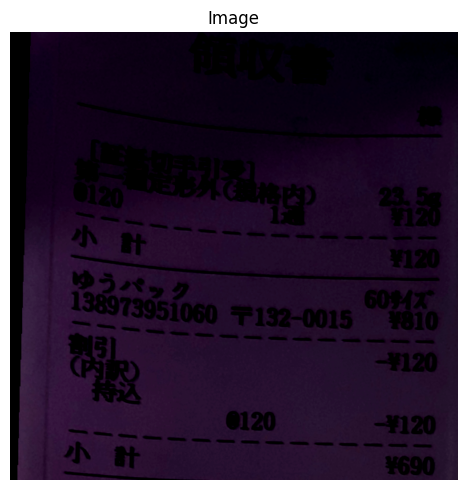

In [34]:
img_sample = img[0].cpu().numpy().transpose(1, 2, 0)  # 채널 순서 조정

print(img[0])
plt.figure(figsize=(10, 5))
plt.imshow(img_sample)  # 이미지 그리기
plt.title("Image")
plt.axis('off')  # 축 숨기기
plt.tight_layout()
plt.show()  # 이미지 표시

Length of gt_geo_map: 5
Bbox 0: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) (Length: 512)
Bbox 1: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) (Length: 512)
Bbox 2: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) (Length: 512)
Bbox 3: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
       

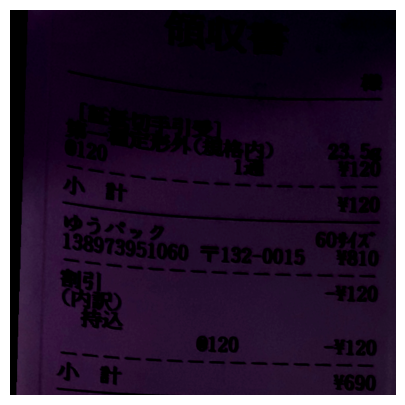

In [27]:
from dataset import get_boundary

def check_gt_geo_map(gt_geo_map):
    print(f"Length of gt_geo_map: {len(gt_geo_map)}")
    for i, bbox in enumerate(gt_geo_map):
        print(f"Bbox {i}: {bbox} (Length: {len(bbox)})")


def visualize_gt_geo_map(image, gt_geo_map):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    
    # 이미지 표시
    ax.imshow(image)
    
    # gt_geo_map을 사용하여 바운딩 박스 그리기
    for bbox in gt_geo_map:
        if len(bbox) == 4:  # bbox가 4개의 값이 있을 경우
            x_min, y_min, x_max, y_max = bbox
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        else:
            print(f"Warning: Expected 4 values in bbox, but got {len(bbox)}. Bbox: {bbox}")
    
    ax.axis('off')  # 축 숨기기
    plt.show()

# 이미지와 gt_geo_map 확인
image = img[0].cpu().numpy().transpose(1, 2, 0)  # 채널 순서 조정
gt_geo_map = gt_geo_map[0]  # 첫 번째 이미지의 gt_geo_map 가져오기

# gt_geo_map 확인
check_gt_geo_map(gt_geo_map)

# 시각화
visualize_gt_geo_map(image, gt_geo_map)


In [28]:
def draw_bboxes(ax, gt_geo_map):
    # gt_geo_map을 사용하여 바운딩 박스를 그리는 함수
    for bbox in gt_geo_map:
        # bbox는 [x_min, y_min, x_max, y_max] 형태라고 가정
        x_min, y_min, x_max, y_max = bbox
        
        # 바운딩 박스를 그리기
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

def save_augmented_samples(data_loader, num_samples=30, save_path="/data/ephemeral/home/ES-datacentric-cv-09/code/data/augmented_samples.jpg"):
    img_samples = []
    geo_maps = []  # gt_geo_map을 저장할 리스트 추가
    
    for img, gt_score_map, gt_geo_map, roi_mask in data_loader:
        for i in range(min(num_samples - len(img_samples), img.size(0))):
            img_sample = img[i].cpu().numpy()
            geo_map_sample = gt_geo_map[i].cpu().numpy()  # 개별 gt_geo_map을 CPU로 변환
            
            img_samples.append(img_sample)
            geo_maps.append(geo_map_sample)  # gt_geo_map도 저장
            
            if len(img_samples) >= num_samples:
                break
        if len(img_samples) >= num_samples:
            break

    num_rows = (num_samples + 7) // 8
    fig, axs = plt.subplots(num_rows, 8, figsize=(20, 5 * num_rows))
    
    for i in range(num_samples):
        ax = axs[i // 8, i % 8]
        img_sample = img_samples[i].transpose(1, 2, 0)  # 채널 순서 조정
        ax.imshow(img_sample)
        
        # gt_geo_map을 사용하여 바운딩 박스 그리기
        draw_bboxes(ax, geo_maps[i])
        
        ax.axis('off')

    plt.tight_layout(pad=0.5)  # 패딩을 줄여서 간격을 좁힘
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # 수평, 수직 간격 조정
    plt.savefig(save_path, bbox_inches='tight')
    plt.close(fig)
    print(f"Augmented samples with bounding boxes saved to {save_path}")


ValueError: too many values to unpack (expected 4)

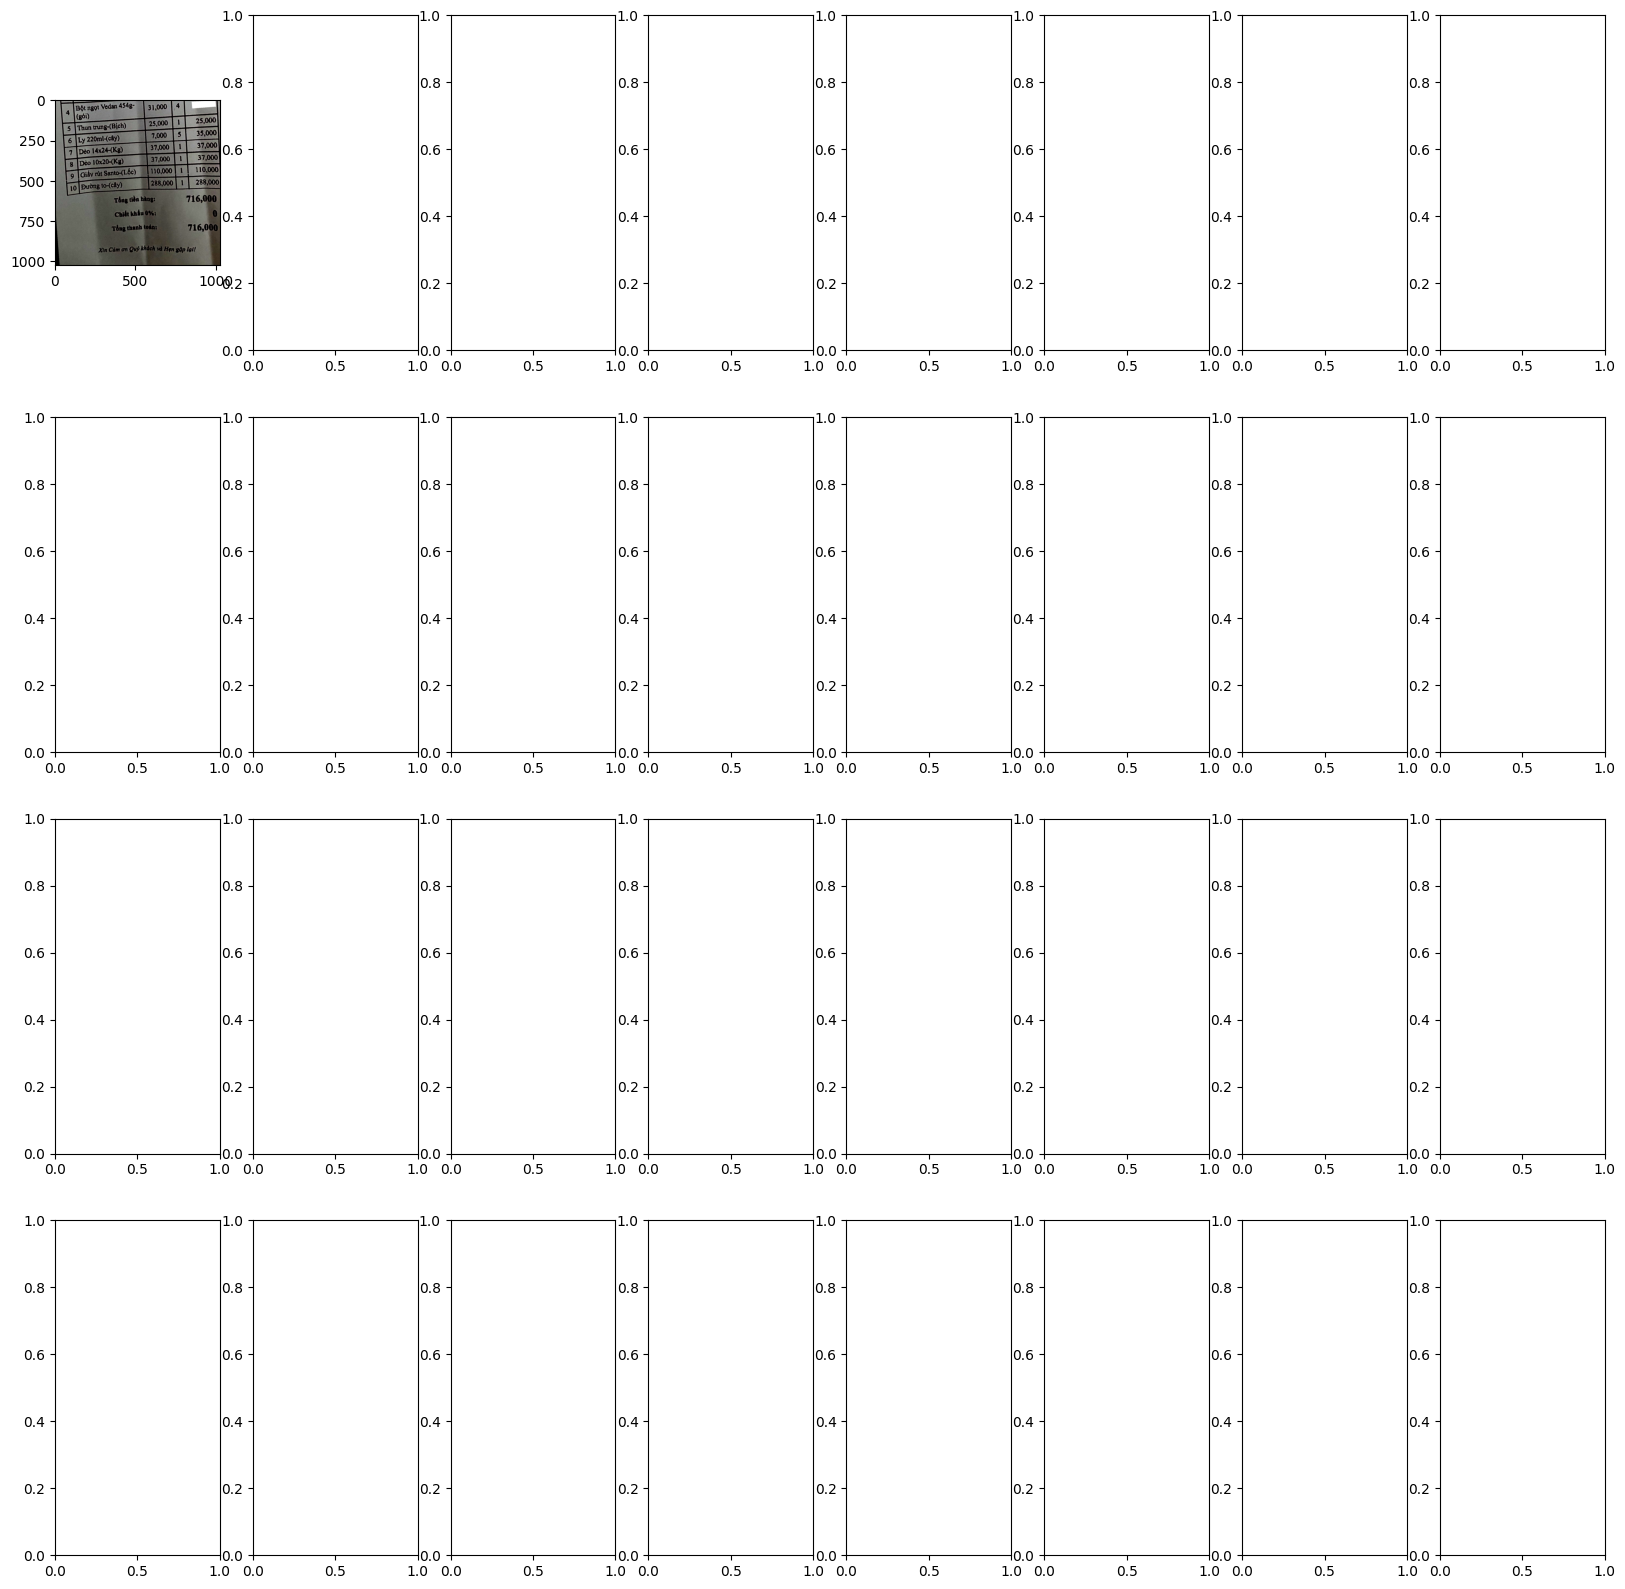

In [29]:
# Augmentation이 적용된 샘플 이미지 30장 저장
save_augmented_samples(train_loader, num_samples=30, save_path="/data/ephemeral/home/ES-datacentric-cv-09/code/data/augmented_samples.jpg")

In [ ]:


    # 첫 번째 배치 가져오기
for img, gt_score_map, gt_geo_map, roi_mask in train_loader:
    print("Batch image shape:", img.shape)  # 배치의 이미지 형태
    print("Batch GT score map shape:", gt_score_map.shape)
    print("Batch GT geo map shape:", gt_geo_map.shape)
    print("Batch ROI mask shape:", roi_mask.shape)
    break  # 첫 번째 배치만 확인

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EAST()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.solver.lr)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[config.solver.max_epoch // 2], gamma=0.1)

model.train()
for epoch in range(config.solver.max_epoch):
    epoch_loss, epoch_start = 0, time.time()
    with tqdm(total=num_batches) as pbar:
        for img, gt_score_map, gt_geo_map, roi_mask in train_loader:
            pbar.set_description('[Epoch {}]'.format(epoch + 1))

            loss, extra_info = model.train_step(img, gt_score_map, gt_geo_map, roi_mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_val = loss.item()
            epoch_loss += loss_val

            pbar.update(1)
            val_dict = {
                'Cls loss': extra_info['cls_loss'], 'Angle loss': extra_info['angle_loss'],
                'IoU loss': extra_info['iou_loss']
            }
            pbar.set_postfix(val_dict)
            wandb.log({"Cls loss": extra_info['cls_loss'],"Angle loss": extra_info['angle_loss'], "IoU loss": extra_info['iou_loss']})

    scheduler.step()

    mean_loss = epoch_loss / num_batches
    elapsed_time = timedelta(seconds=time.time() - epoch_start)
    print(f'Mean loss: {mean_loss:.4f} | Elapsed time: {elapsed_time}')
    wandb.log({"Mean loss": mean_loss})

    # Update log file
    update_log(log_dir, epoch, mean_loss, elapsed_time)

    # Save checkpoint at intervals
    if (epoch + 1) % config.data.save_interval == 0:
        ckpt_fpath = osp.join(log_dir, f"epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), ckpt_fpath)

# save confog file
config_file_path = args.config
shutil.copy(config_file_path, os.path.join(log_dir, os.path.basename(config_file_path)))

latest_ckpt_fpath = osp.join(log_dir, f"latest.pth")
torch.save(model.state_dict(), latest_ckpt_fpath)
